In [197]:
# Import Statements
from urllib.parse import urlparse
import re
import requests
import zipfile

import glob
from matplotlib import pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

In [106]:
# Various cell magic things we may want as we investigate this.

%matplotlib inline

In [107]:
# Any state we want to load for the whole notebook
# I know it should probably be "NLP" in order to be more consistent, but nlp is the common usage

nlp = spacy.load('en')

In [110]:
# Load external ("raw") data.
# URL we will need to use(?)
data_address = "https://archive.ics.uci.edu/ml/machine-learning-databases/00438/Health-News-Tweets.zip"
request = requests.get(data_address, allow_redirects=True)
data_dir = 'Health-News-Tweets'
open('Health-News-Tweets.zip', 'wb').write(request.content)
# Extract zipfile
with zipfile.ZipFile("Health-News-Tweets.zip", 'r') as zip_ref:
    zip_ref.extractall('Health-News-Tweets')

In [111]:
# Create data frame
tweet_frame = pd.DataFrame(columns=["text"])

# Loop over files in data dir, load and append to dataframe
texts = []
for filename in glob.glob("Health-News-Tweets/Health-Tweets/*.txt"):
    # only take the last column ([2]) because this analysis will only comprise text
    print(filename)
    with open(filename, "r", encoding='latin-1') as targetfile:
        # Note for posterity, discovering this is supposed to be latin-1 was a major headache
        lines = targetfile.readlines()
        # Note: pandas had some issues loading this, so falling back to regex
        filetexts = [re.sub(".*\|.*\|", "", s) for s in lines]
    texts.extend(filetexts)

Health-News-Tweets/Health-Tweets/cbchealth.txt
Health-News-Tweets/Health-Tweets/wsjhealth.txt
Health-News-Tweets/Health-Tweets/nprhealth.txt
Health-News-Tweets/Health-Tweets/goodhealth.txt
Health-News-Tweets/Health-Tweets/NBChealth.txt
Health-News-Tweets/Health-Tweets/cnnhealth.txt
Health-News-Tweets/Health-Tweets/foxnewshealth.txt
Health-News-Tweets/Health-Tweets/everydayhealth.txt
Health-News-Tweets/Health-Tweets/gdnhealthcare.txt
Health-News-Tweets/Health-Tweets/nytimeshealth.txt
Health-News-Tweets/Health-Tweets/bbchealth.txt
Health-News-Tweets/Health-Tweets/KaiserHealthNews.txt
Health-News-Tweets/Health-Tweets/usnewshealth.txt
Health-News-Tweets/Health-Tweets/latimeshealth.txt
Health-News-Tweets/Health-Tweets/reuters_health.txt
Health-News-Tweets/Health-Tweets/msnhealthnews.txt


In [112]:
# Check dataset
# Note, it seems like 'wc -l *' yields 63325 total lines, so the number of broken/halved tweets should be pretty small
# Good to test consistency of that anyway.
len(texts) # 63327

63327

In [113]:
# Begin generic text processing
# running this more than once does nothing, note for jupyter notebook
texts = [t.strip() for t in texts]

In [114]:
# Analytics section
# Create data frame
text_frame = pd.DataFrame(texts, columns=['text'])

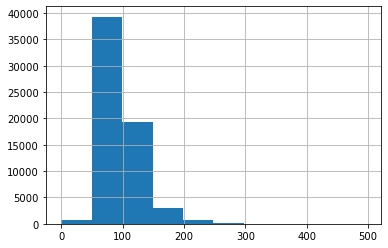

In [115]:
# Get an idea of the text lengths

text_frame.text.map(len).hist()

In [116]:
# Define 

# A custom tokenizer that uses spacy (for generally having good tokenization rules) and limited URL handling
# I decided not to write a custom matcher for spacy, and so hashtags and emojis will not be properly handled.
# urls will be reduced to their netloc and @user identifications will be fine though. Dangling #s will just disappear.
def spacy_tokenize(text):
    doc = nlp(text)
    # replace URLs with netloc, lowercase, remove punctuation.
    tokens = [tok for tok in doc if not (tok.is_punct or tok.text in STOP_WORDS)]
    tokens = [tok.lemma_.lower()
              for tok in tokens
              if not tok.like_url]
    
    # Code for replacing URLs with netloc
    #tokens = [tok.lemma_.lower() 
    #if not tok.like_url 
    #          else urlparse(tok.text.lower()).netloc
    #          for tok in tokens]
    return tokens
    

www.GOOGLE.com


In [118]:
# Vectorize text data
# Note: combining an idf score with LDA is a well known hack. Roughly speaking, it should help denoise
# the vectors, since everything looks at proportions anyway--less 'informative' words become a lower proportion
# of the total of 'words' we are observing

# Note: Stopwords are removed in the spaCy tokenizer before lemmatization.
vectorizer = TfidfVectorizer(use_idf=True, max_features=5000, tokenizer=spacy_tokenize)

# This should take a bit.
text_bow_vectors = vectorizer.fit_transform(text_frame.text)

# Run LDA

I chose LDA for clustering because it is generally a good option for texts. As tweets are very short and therefore sparse, I did consider using NMF for this dataset. However I feel that the length of these tweets is unlikely to be a good separating feature, so I chose LDA for the smoothing effect of its priors. Since we have a decent amount of data we should be able to smooth out the difficulties caused by very sparse rows.

In [120]:
# Initialize model with parameters
lda = LatentDirichletAllocation(n_components=10, doc_topic_prior=1/20, topic_word_prior=1/10)

In [121]:
# Train LDA model
doc_topic_matrix = lda.fit_transform(text_bow_vectors)

In [122]:
# Visualize and analyze lda
n_samples = 2000
n_features = len(vectorizer.vocabulary_)
n_components = 10
n_top_words = 20

# Function for printing out topic summary
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [123]:
# Create labels (for later use) based on classifications
labels = np.argmax(doc_topic_matrix, axis=1)

# Cluster analysis

## Top words

In [124]:
print("\nTopics in LDA model:")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: cancer   risk study breast woman @goodhealth @cynthiasas heart weight help rt ¦ loss find exercise man link brain stress
Topic #1: $ nhs cigarette care health e rt new hospital smoking doctor pharma video healthcare patient @pharmalot staff smoker tobacco act
Topic #2: rt healthtalk nhs ¦ thank join health @gdnhealthcare today question like live chat answer miss amp love doctor viewsfromthenhsfrontline care
Topic #3:   study old age flu kid new find blog help bird teen sleep brain risk say adult child live school
Topic #4: ebola u.s patient hospital new health africa doctor liberia say outbreak fight west worker nurse drug   test case quarantine
Topic #5: food healthy way eat recipe try tip workout 10 fat good day 5 calorie diet weight lose exercise bad know
Topic #6: leone sierra rt cell ebola virus life stem patient audio video doctor   end ¦ wait new health nhs help
Topic #7: drug fda rt cartoon cancer approve today c @stefaniei new   @wsj painkiller 

## Topic assignment

Based on the above associated kewords I would suggest the following topic assignments:

- Topic #0: Cancer
- Topic #1: Smoking
- Topic #2: Health information
- Topic #3: Age related medicine
- Topic #4: Ebola
- Topic #5: Weight loss and dieting
- Topic #6: Sierra Leone
- Topic #7: Drug trials
- Topic #8: Health insurance
- Topic #9: Disease

The topics have a degree overlap, for instance there are multiple that address serious diseases. If the objective is to obtain the most meaningful topic classifications, this might suggest a smaller number of topics should be employed on the hopes that several of these categories will merge. Signs are good however that sufficient information exists in the dataset to perform useful classification.



In [133]:
# Human assigned labels for clusters
label_dict = {0: "cancer",
              1: "smoking",
              2: "information",
              3: "age",
              4: "ebola",
              5: "weight",
              6: "sierra",
              7: "drug",
              8: "insurance",
              9: "disease"}

'smoking'

## Plot TSNE Clusters and analyze

TSNE was chosen for visualization for being a common and solid option. It also turned out that viewed this way the data has interesting local structure. See below.

In [126]:
# Initialize TSNE

tsne = TSNE(perplexity=100, learning_rate=300, metric='cosine', early_exaggeration=24, init='pca')

In [134]:
# Fit TSNE
tsne_points = tsne.fit_transform(doc_topic_matrix)

CPU times: user 1h 45s, sys: 3min 27s, total: 1h 4min 12s
Wall time: 10min 53s


[4 9 1 3 2 8 0 6 7 5]


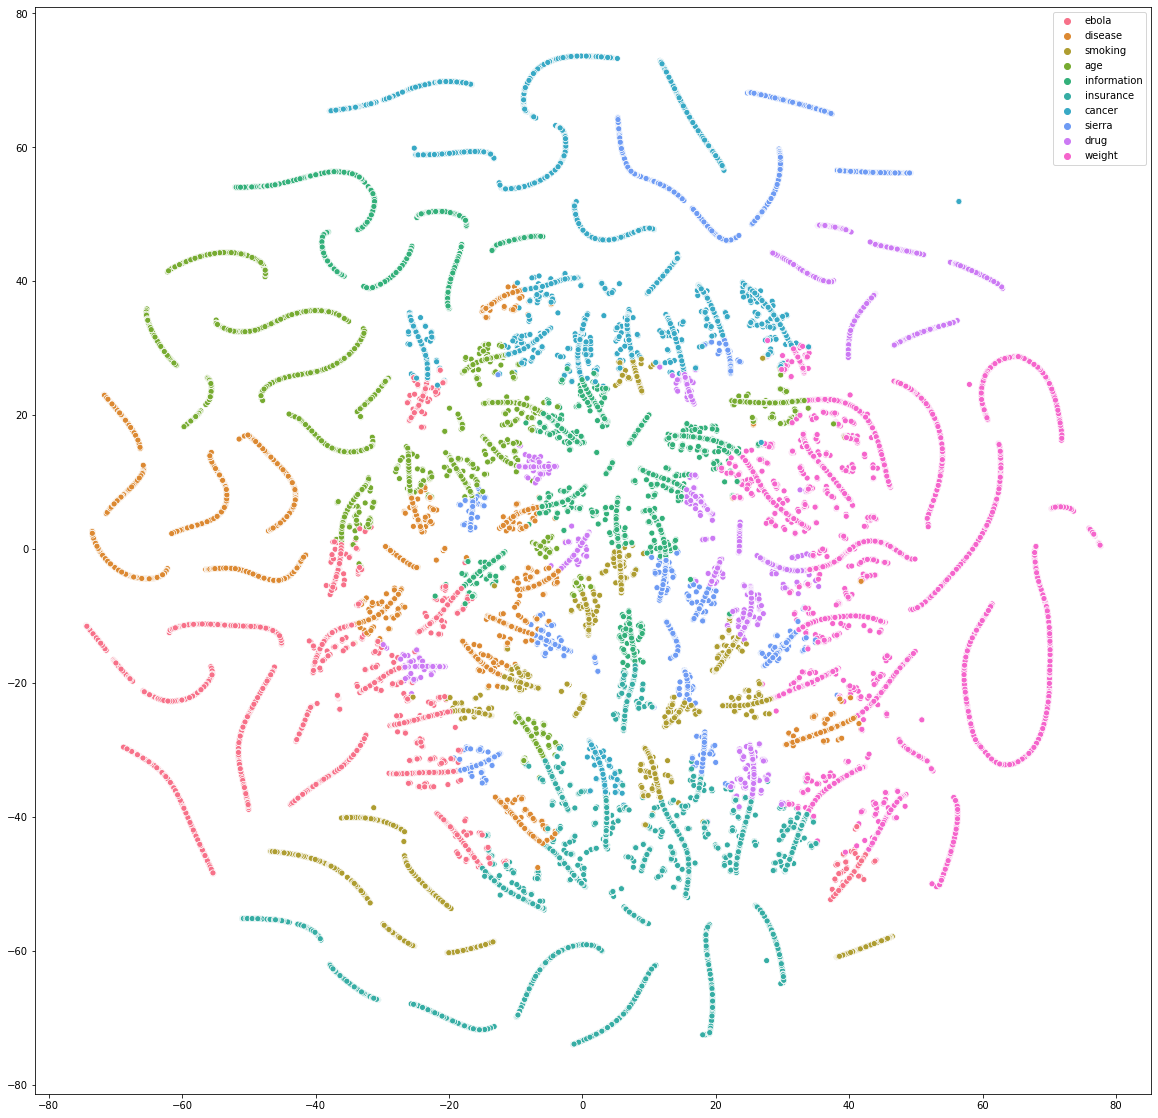

In [135]:
# Plot
print(pd.Series(labels).unique())
plt.figure(figsize=(20,20))
sns.scatterplot(x=tsne_points[:,0],
                y=tsne_points[:,1],
                hue=[label_dict[l] for l in labels],
                palette=sns.color_palette('husl', 10),
                legend='full')

## Analysis of clusters

TSNE is very good at preserving the 'local' structure in data. What this implies about the above plot is that while there are large clusters for each particular category, there are a bunch of clusters (visible as lines that change color) that seem to span several LDA clusters. This provides us a good way of seeing what the edges of our cluster assignment are.

For instance, the Sierra Leone cluster seems to broach a lot of other topics. My guess based on this is that the cluster is either misnamed, or a collection of garbage text that occurs in a bunch of other clusters with some frequency. The insurance cluster also has connections to several other clusters--my preliminary hypothesis is that these are posts discussing coverage of various maladies. The cancer cluster also impinges on weight, smoking etc. This makes sense to me, but I would recommend a deeper dive into the data before attempting to recluster everything.


# Classification

## Choice of classification algorithm

There are several considerations to make when choosing a classification algorithm for this problem. First, since we know that the categories were determined by LDA, we know that we can back out an exact solution to the problem: We could train a smaller LDA model on less data and we would have our predictor. We could even keep the predictor as is and use the .transform method. I'll assume that this classification is for the purpose of bootstraping another classifier or dataset--it may be possible to generalize more effectively by training a model on these 'noisy labels' that LDA has generated for us.

For the reason given above, I will decline to use a Naive Bayes model with bag of words because I believe the math works out so that is more or less recalculating the .transform method for LDA--though we could employ variants of that model.

My go-to first pass model is a logit with a bag of vectors as the feature set. We can use the word tensors (not good enough for proper word vectors, but good enough for our purposes) to predict the desired target from LDA. This stands a good chance of learning some interesting generalization (because of the dense representation we will use for a feature set) as well as being a good baseline classifier for text.





In [168]:
# Processing
def spacy_vectorize(texts):
    return [nlp(text).vector if text is not "" else nlp("empty!").vector*0 for text in texts]

In [170]:
# Initialize classification model, switch to text labels
# Takes about 6 minutes
X = spacy_vectorize(text_frame.text)
y = [label_dict[l] for l in labels]


CPU times: user 6min 31s, sys: 1.44 s, total: 6min 33s
Wall time: 6min 33s


In [199]:
# Check class distribution
pd.Series(y).value_counts()

weight         10545
insurance       7146
cancer          7057
ebola           6963
age             6357
disease         6163
information     5683
smoking         4557
sierra          4477
drug            4379
dtype: int64

In [172]:
# Perform train-test split and restake X to be an array
X_train, X_test, y_train, y_test = train_test_split(np.vstack(X), y, random_state=108)

In [177]:
# Initialize logit model.
# Class imbalance is significant, so will reweighted accordingly
logit = LogisticRegression(class_weight='balanced', max_iter=500)


In [178]:
# Train Logit
logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500)

In [182]:
# Predict and evaluate
yhat = logit.predict(X_test)

print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

              precision    recall  f1-score   support

         age       0.26      0.25      0.26      1575
      cancer       0.30      0.27      0.29      1744
     disease       0.27      0.20      0.23      1601
        drug       0.22      0.25      0.24      1076
       ebola       0.40      0.40      0.40      1716
 information       0.30      0.50      0.37      1405
   insurance       0.35      0.36      0.35      1770
      sierra       0.12      0.07      0.09      1112
     smoking       0.18      0.19      0.19      1116
      weight       0.52      0.52      0.52      2717

    accuracy                           0.33     15832
   macro avg       0.29      0.30      0.29     15832
weighted avg       0.32      0.33      0.32     15832

[[ 400  204  135  125  102  137  129   57   89  197]
 [ 224  468  119  105   71  236  118   60   99  244]
 [ 169  145  319  118  240  121  152   82  137  118]
 [  71   75   92  272  106  107  140   46   91   76]
 [ 113   76  156  141  680   

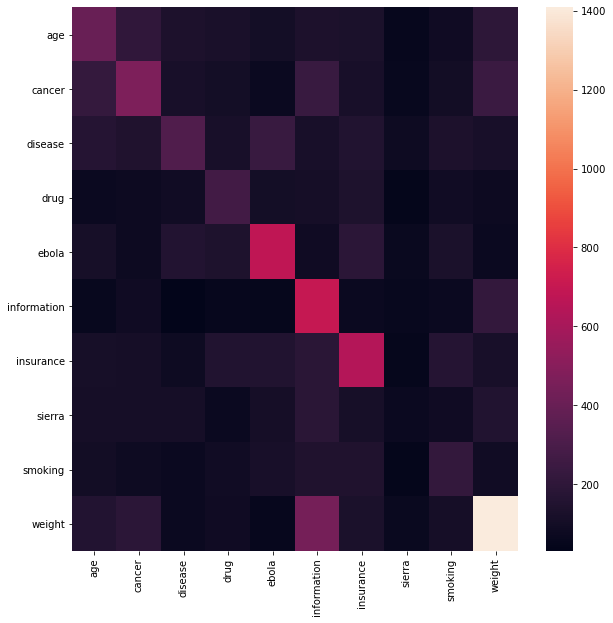

In [200]:
# Heat map for easier viewing of the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, yhat),
            xticklabels=logit.classes_,
            yticklabels=logit.classes_)

# Analysis

The baseline classifier does better than random, though there is definitely a great deal of room for improvement. The numbers are better than a uniform random approach or fitting the class distribution, with the exception of the 'sierra' class. As referrenced earlier, there is a possibility that this class is just junk.

## Areas to improve

Since we have sufficient data, moving to a higher-dimensional representation is called for. Another pass at clustering the data in order to produce better clusters may help, but that depends on what the desired label is. If the goal is some kind of transfer learning I would recommend fine tuning a larger model on this dataset, as well as 'gold' label collection if possible. 